In [29]:
from deep_rl.gridworld import ReachGridWorld, PORGBEnv, ReachGoalManager
from ipdb import slaunch_ipdb_on_exception
from random import shuffle
from collections import Counter
import random
import argparse
import dill
import numpy as np
import matplotlib.pyplot as plt

def seed(s):
    random.seed(s)
    np.random.seed(s)
    
def in_ipy():
    try:
        get_ipython()
        return True
    except:
        return False

IN_IPY = in_ipy()
if IN_IPY:
    print('### in ipython ###')
    from IPython.display import display
    from PIL import Image
else:
    print('### in terminal ###')
seed(0) # set seed

parser = argparse.ArgumentParser()
parser.add_argument('--method', choices=['cluster'], default='cluster')
parser.add_argument('--n_goal', type=int, default=1)
parser.add_argument('--min_dis', type=int, default=3)
parser.add_argument('--n_abs', type=int, default=4)
if IN_IPY:
    args = parser.parse_args([])
else:
    args = parser.parse_args() 
    
class one_hot:
    # 1 or 2 dim
    @staticmethod
    def encode(indices, dim):
        if len(indices.shape) > 1:
            indices = indices.squeeze(axis=1)
        assert len(indices.shape) == 1, 'shape error'
        return np.eye(dim)[indices]

    # 2-dim
    @staticmethod
    def decode(vs):
        return np.argmax(vs, 1)

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 10)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.1 * v)) for v in range(1, 10)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.1 * v)) for v in range(1, 10)],
    *[('green-{}'.format(v), plt.cm.Greens(0.1 * v)) for v in range(1, 10)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.1 * v)) for v in range(1, 10)],
    *[('red-{}'.format(v), plt.cm.Reds(0.1 * v)) for v in range(1, 10)],
])

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
visualization_map = dict([
    ('G', 0),
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 45)],
])

### in ipython ###


In [33]:
def cluster_abstraction(env, n_abs):
    from sklearn.cluster import KMeans
    n_action = env.action_space.n
    env.reset()
    goals = [env.i2g[combo[1]] for combo in env.train_combos]
    states = [s for s in env.pos_candidates if s not in goals]
    m = [[] for _ in range(len(states))]
    for combo in env.train_combos:
        env.reset(index=combo)
        for i, s in enumerate(states):
            env.teleport(*s)
            qs = np.array(env.get_q(0.99))
            best_actions = (qs == qs.max()).astype(int)
            sample_action = one_hot.encode(np.random.choice(np.argwhere(best_actions).squeeze(1), size=1), n_action)[0]
            #print('{}: {}, {}'.format(s, best_actions, sample_action))
            m[i].append(sample_action)
            #m[i].append(best_actions)
    m = np.array([np.concatenate(row) for row in m])
    kmeans = KMeans(n_clusters=n_abs, random_state=0).fit(m)
    return {s: label for s, label in zip(states, kmeans.labels_)}
    
def visualize(abstract_map, env):
    m = env.get_map(0)
    print('labels:', set(abstract_map.values()))
    print('count on labels:', Counter(abstract_map.values()))
    for i in range(len(m)):
        for j in range(len(m[i])):
            if m[i][j] == '#': continue
            elif (i, j) in abstract_map:
                m[i][j] = str(abstract_map[(i, j)])
            else:
                m[i][j] = 'G'
    #for row in m:
    #    print(' '.join(row))
    drawer = GridDrawer(color_list)
    img = drawer.draw([[visualization_map[m[i][j]] for j in range(len(m[i]))] for i in range(len(m))])
    display(Image.fromarray(img))
    
def save_abs(abs_dict, fn):
    with open(fn, 'wb') as f:
        dill.dump(abs_dict, f)
    
def load_abs(fn):
    with open(fn, 'rb') as f:
        return dill.load(fn)
    
def abs_fn(args):
    return 'abs/{}-n_goal-{}-n_abs-{}.pkl'.format(args.method, args.n_goal, args.n_abs)
    
# input: an environment and the corresponding index (map_id, gx, gy)
# output: an identity map of this map_id and task
def get_identity_map(env, index):
    index = (index[0], env.unwrapped.g2i[index[1:]])
    env.reset(index=index)
    goal = (env.unwrapped.gx, env.unwrapped.gy)
    states = [s for s in env.pos_candidates if s != goal]
    n_states = len(states)
    id_map = dict([(s, i) for i, s in enumerate(states)])
    #print(id_map)
    return id_map
    
def main():
    map_names = ['map49']
    #goal_manager = ReachGoalManager(map_names[0])
    # min_dis between goals (approximation of corelation)
    #goals = goal_manager.gen_goals(args.n_goal + 1, min_dis=args.min_dis) 
    #train_combos = [(0,) + goal for goal in goals[:args.n_goal]]
    #test_combos = [(0,) + goal for goal in goals[args.n_goal:]]
    train_combos = [(0, 1, 1)]
    test_combos = [(0, 2, 2)]
    env = ReachGridWorld(map_names, train_combos, test_combos)
    #if args.method == 'cluster':
        # abstract_map {(x, y): abstract state index}
        #abstract_map = cluster_abstraction(env, args.n_abs)
    #visualize(abstract_map, env)
    #save_abs({0: abstract_map}, os.path.join('abs', 'map49-0-1-1.pkl'))
    save_abs({0: get_identity_map(env, (0, 1, 1))}, os.path.join('abs', 'map49-id.pkl'))
    
if __name__ == '__main__':
    seed(0)
    if in_ipy:
        main()
    else:
        with slaunch_ipdb_on_exception():
            main()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 0)]
test: [(0, 1)]
{(1, 2): 0, (1, 3): 1, (1, 4): 2, (1, 5): 3, (1, 6): 4, (1, 7): 5, (1, 8): 6, (1, 9): 7, (1, 11): 8, (1, 12): 9, (1, 13): 10, (1, 14): 11, (2, 1): 12, (2, 2): 13, (2, 3): 14, (2, 4): 15, (2, 6): 16, (2, 7): 17, (2, 8): 18, (2, 9): 19, (2, 11): 20, (2, 12): 21, (2, 13): 22, (2, 14): 23, (3, 1): 24, (3, 2): 25, (3, 3): 26, (3, 4): 27, (3, 6): 28, (3, 7): 29, (3, 8): 30, (3, 9): 31, (3, 11): 32, (3, 12): 33, (3, 13): 34, (3, 14): 35, (4, 1): 36, (4, 2): 37, (4, 3): 38, (4, 4): 39, (4, 6): 40, (4, 7): 41, (4, 8): 42, (4, 9): 43, (4, 11): 44, (4, 12): 45, (4, 13): 46, (4, 14): 47, (5, 1): 48, (5, 8): 49, (5, 14): 50, (6, 1): 51, (6, 2): 52, (6, 3): 53, (6, 4): 54, (6, 6): 55, (6, 7): 56, (6, 8): 57, (6, 9): 58, (6, 11): 59, (6, 12): 60, (6, 13): 61, (6, 14): 62, (7, 1): 63, (7, 2): 64, (7, 3): 65, (7, 4): 66, (7, 6): 67, (7, 7): 68, (7, 8): 6

# of colors: 47


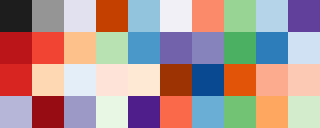

In [12]:
drawer = GridDrawer(color_list=color_list)
print('# of colors:', len(drawer.color_list))
img = Image.fromarray(drawer.draw(np.arange(40).reshape((4, 10)), repeat=32))
#img = Image.fromarray(drawer.draw([[0, 1], [2,3]], repeat=32))
display(img)

In [25]:
import torch as th
a = th.zeros((3, 4))
b = th.zeros((3, 4, 5)).to(a.device)
th.is_tensor(a)

True